<a href="https://colab.research.google.com/github/andreidore/aicrowd_blitz_may_2020/blob/master/minileaves_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install wandb==0.8.33


     |████████████████████████████████| 1.4MB 4.6MB/s 
     |████████████████████████████████| 460kB 27.3MB/s 
     |████████████████████████████████| 112kB 37.4MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=c02b484778efb6c23f48e9e0d0ec98c348b94557efc202d15e5ed59fbb9c36a5
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=3d4db0525977476e51ac95736d6e3899beed9b6d47a2fefe07835ced86637b9b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=

In [4]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-05-09 18:54:13--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.16, 130.117.252.10, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133527680 (127M) [binary/octet-stream]
Saving to: ‘train-images.npy.1’

train-images.npy.1  100%[===================>] 127.34M  22.0MB/s    in 6.8s    

2020-05-09 18:54:20 (18.7 MB/s) - ‘train-images.npy.1’ saved [133527680/133527680]

--2020-05-09 18:54:21--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.16, 130.117.252.10, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.11

In [0]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import resnet50,vgg19
from tensorflow.keras import regularizers, optimizers
import matplotlib.pyplot as plt
%matplotlib inline
import wandb
from wandb.keras import WandbCallback

In [6]:
wandb.init(name='CNN-transfer', project="minileaves",config={"hyper": "parameter"})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/andrei-dore/minileaves/runs/i1npl6lw

## Import data

In [0]:
train_images_path = "train-images.npy" #path where data is stored
train_labels_path = "train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

# Load Class mapping
class_names = [x.strip() for x in open("all_classes.txt").readlines()]

In [8]:
print(train_images.shape)
print(train_labels.shape)
print(train_labels[0:10])
print(class_names)


(43466, 32, 32, 3)
(43466,)
[ 7  4  9 29 20 15 37  5 29 28]
['apple-apple-scab', 'apple-black-rot', 'apple-cedar-apple-rust', 'apple-healthy', 'blueberry-healthy', 'cherry-including-sour-healthy', 'cherry-including-sour-powdery-mildew', 'corn-maize-cercospora-leaf-spot-gray-leaf-spot', 'corn-maize-common-rust', 'corn-maize-healthy', 'corn-maize-northern-leaf-blight', 'grape-black-rot', 'grape-esca-black-measles', 'grape-healthy', 'grape-leaf-blight-isariopsis-leaf-spot', 'orange-haunglongbing-citrus-greening', 'peach-bacterial-spot', 'peach-healthy', 'pepper-bell-bacterial-spot', 'pepper-bell-healthy', 'potato-early-blight', 'potato-healthy', 'potato-late-blight', 'raspberry-healthy', 'soybean-healthy', 'squash-powdery-mildew', 'strawberry-healthy', 'strawberry-leaf-scorch', 'tomato-bacterial-spot', 'tomato-early-blight', 'tomato-healthy', 'tomato-late-blight', 'tomato-leaf-mold', 'tomato-septoria-leaf-spot', 'tomato-spider-mites-two-spotted-spider-mite', 'tomato-target-spot', 'tomato-

## Visualize date

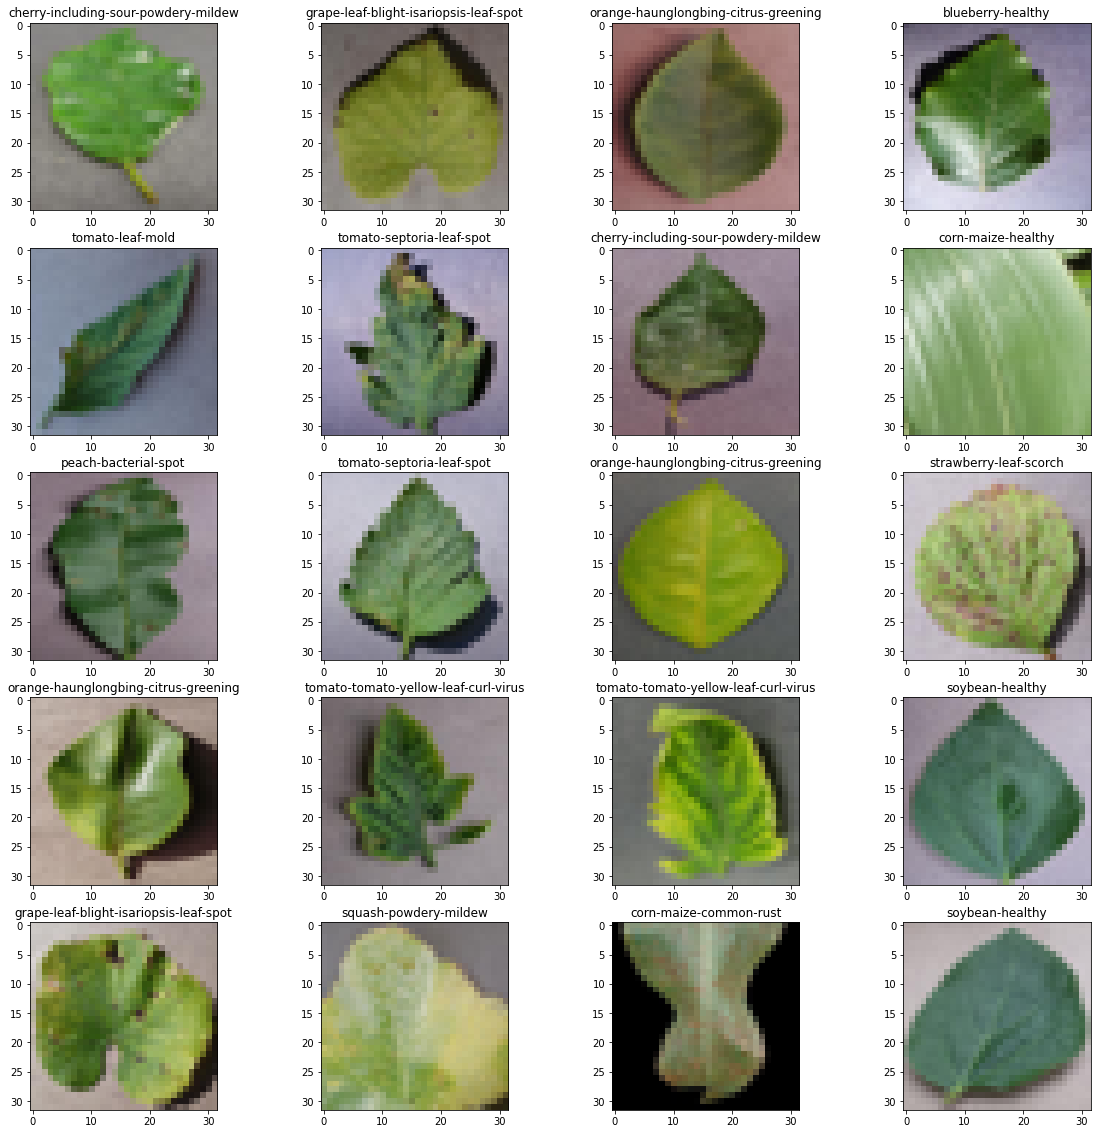

In [9]:
def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name



fig=plt.figure(figsize=(20, 20))
w=10
h=10
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    image,class_label,class_name=random_data_sample()
    plt.imshow(image)
    plt.title(class_name)

## Distribution

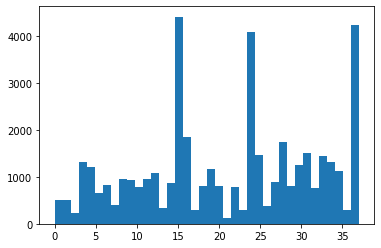

In [10]:
#data_counter = Counter(train_labels)
#unique_class_indices = data_counter.keys()

#for _class_index in unique_class_indices:
#    print("Class Index : ", _class_index)
#    print("Class Name : ", class_names[_class_index])
#    print("Number of images in the dataset : ", data_counter[_class_index])
#    print("="*100)



plt.hist(train_labels, bins = 38)
plt.show()


In [0]:
X_train, X_val= train_test_split(train_images, test_size=0.2, random_state=42)
y_train, y_val= train_test_split(train_labels, test_size=0.2, random_state=42)

In [12]:
base_model = vgg19.VGG19(weights = "imagenet", include_top=False, input_shape=(32,32,3))
base_model.summary()


80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [13]:
#for layer in base_model.layers:
#    layer.trainable = False
#
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [14]:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

num_classes = len(np.unique(y_train))


# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add 2 FC layers, each has 4096 units and relu activation 
x = Dense(512, activation='relu', name='FC_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# add our new softmax layer with 3 hidden units
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=vgg19.preprocess_input
    )

# compute the data augmentation on the training set
datagen.fit(X_train)

In [0]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
X_val=vgg19.preprocess_input(X_val)

In [0]:
optimizer = Adam(lr=0.0005,decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
# compile the model


model_checkpoint=ModelCheckpoint(filepath="best_model.hdf5",verbose=1,save_best_only=True)
wand_callback=WandbCallback()

batch_size=32

history=model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0] // batch_size,epochs=50,verbose=2,
          callbacks=[model_checkpoint,wand_callback],validation_data=(X_val,y_val),shuffle=True)

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.65694, saving model to best_model.hdf5
1086/1086 - 30s - loss: 3.2390 - accuracy: 0.1979 - val_loss: 2.6569 - val_accuracy: 0.2436
Epoch 2/50

Epoch 00002: val_loss improved from 2.65694 to 2.54091, saving model to best_model.hdf5
1086/1086 - 30s - loss: 2.7015 - accuracy: 0.2587 - val_loss: 2.5409 - val_accuracy: 0.2769
Epoch 3/50

Epoch 00003: val_loss improved from 2.54091 to 2.46460, saving model to best_model.hdf5
1086/1086 - 31s - loss: 2.5861 - accuracy: 0.2756 - val_loss: 2.4646 - val_accuracy: 0.2784
Epoch 4/50

Epoch 00004: val_loss did not improve from 2.46460
1086/1086 - 28s - loss: 2.2007 - accuracy: 0.3407 - val_loss: 2.7534 - val_accuracy: 0.2844
Epoch 5/50

Epoch 00005: val_loss improved from 2.46460 to 1.57377, saving model to best_model.hdf5
1086/1086 - 30s - loss: 1.8215 - accuracy: 0.4320 - val_loss: 1.5738 - val_accuracy: 0.4974
Epoch 6/50

Epoch 00006: val_loss improved from 1.57377 to 1.37676, saving model 

In [0]:
model.load_weights('best_model.hdf5')

In [0]:
scores = model.evaluate(X_val, y_val, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

68/68 [==============================] - 0s 4ms/step - loss: 0.1288 - accuracy: 0.9587

Test result: 95.871 loss: 0.129


In [0]:
test_file_path = "test-images.npy"
test_images = np.load(test_file_path)

In [0]:
test_images=test_images.astype('float32')/255
#test_images = (test_images-mean)/(std+1e-7)

In [0]:
submission=model.predict(test_images)

In [0]:

submission=np.argmax(submission,axis=1)
print(submission.shape)

(10838,)


## Save the prediction to csv

In [0]:
import pandas as pd
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv',header=['class_index'],index=False)

## To download the generated csv in colab run the below command

In [0]:
from google.colab import files
files.download('submission.csv')